In [285]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib
import protos_pb2
import protos_pb2_grpc
import grpc

In [385]:
channel = grpc.insecure_channel('127.0.0.1:8080')
stub = protos_pb2_grpc.DataServiceStub(channel)

request = protos_pb2.GetPriceHistoryRequest()
request.symbol.name = protos_pb2.Symbol.BITCOIN
request.symbol.broker = protos_pb2.Broker.XTB_DEMO
#request.window_nanoseconds = 300000000000 # 5 minutes
request.window_nanoseconds = 60000000000 # 1 minute

result = stub.GetPriceHistory(request)

In [386]:
data = []

for candlestick in result.candlesticks:
    ts = candlestick.timestamp.ToJsonString()
    data.append({
        "time": pd.to_datetime(ts),
        "low":   float(candlestick.low)  / 1000000,
        "high":  float(candlestick.high) / 1000000,
        "open":  float(candlestick.open) / 1000000,
        "close": float(candlestick.close) / 1000000,
    })

df = pd.DataFrame(data)
indexed = df.set_index('time')

df.head()

,time,low,high,open,close
0,2020-03-08 22:06:00+00:00,8367.549999,8371.700000,8371.260000,8369.860000
1,2020-03-08 22:07:00+00:00,8363.559999,8376.799999,8368.980000,8370.219999
2,2020-03-08 22:08:00+00:00,8369.469999,8385.820000,8370.459999,8379.590000
3,2020-03-08 22:09:00+00:00,8367.379999,8379.690000,8379.350000,8372.330000
4,2020-03-08 22:10:00+00:00,8369.660000,8375.170000,8370.920000,8371.389999


In [387]:
fig = go.Figure(data=[go.Candlestick(x=df['time'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.show()

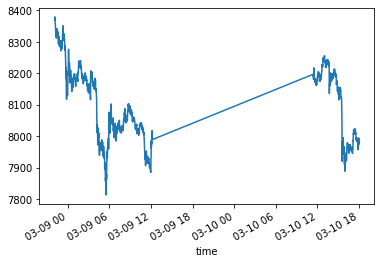

In [388]:
close = indexed['close']
close.plot()

46.63175434420348
overbought: False
oversold: False


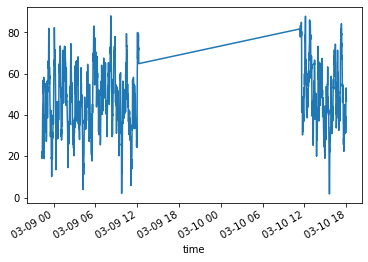

In [389]:
class RelativeStrengthIndex():
    rsi = 0.0
    overbought = 0.0
    oversold = 0.0
    
    def __init__(self, values, windowPeriods, overbought, oversold):
        self.overbought = overbought
        self.oversold = oversold
        
        delta = values.diff()
        delta = delta[1:]
        
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        
        roll_up = up.rolling(windowPeriods).mean()
        roll_down = down.abs().rolling(windowPeriods).mean()
        
        relative_strength = roll_up / roll_down
        self.rsi = 100.0 - (100.0 / (1.0 + relative_strength))
        
    def plot(self):
        self.rsi.plot()
        
    def current_value(self):
        return self.rsi.tail(1)[0]
        
    def is_overbought(self):
        return self.current_value() >= self.overbought
        
    def is_oversold(self):
        return self.current_value() >= self.overbought

rsi = RelativeStrengthIndex(close, windowPeriods = 14, overbought = 70, oversold = 30)
rsi.plot()

current_value = rsi.current_value()
print(current_value)

overbought = rsi.is_overbought()
oversold = rsi.is_oversold()
print("overbought:", overbought)
print("oversold:", oversold)

(8002.51715648944, 7957.556843510553, 7980.036999999997)
above upper band: False
below upper band: True
above lower band: True
below lower band: False
above moving average: False
below moving average: True


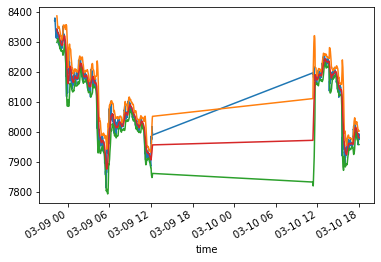

In [390]:
class BollingerBands():
    values = 0.0
    upper = 0.0
    lower = 0.0
    ma = 0.0
    
    def __init__(self, values, windowPeriods, deviation):
        self.values = values
        self.ma = values.rolling(window = windowPeriods).mean()
        std = values.rolling(window = windowPeriods).std()
        
        self.upper = self.ma + (std * deviation)
        self.lower = self.ma - (std * deviation)
        
    def plot(self):
        self.values.plot()
        self.upper.plot()
        self.lower.plot()
        self.ma.plot()
        
    # tuple of (upper, lower, ma)
    def current_values(self):
        return (self.upper.tail(1)[0], self.lower.tail(1)[0], self.ma.tail(1)[0])
    
    def is_above_upper_band(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] > upper
        
    def is_below_upper_band(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] < upper
    
    def is_above_lower_band(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] > lower
    
    def is_below_lower_band(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] < lower
    
    def is_above_moving_average(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] > ma
    
    def is_below_moving_average(self):
        upper, lower, ma = self.current_values()
        return self.values.tail(1)[0] < ma
    
    
bollinger_bands = BollingerBands(close, windowPeriods = 20, deviation = 2)
bollinger_bands.plot()
print(bollinger_bands.current_values())
print("above upper band:", bollinger_bands.is_above_upper_band())
print("below upper band:", bollinger_bands.is_below_upper_band())
print("above lower band:", bollinger_bands.is_above_lower_band())
print("below lower band:", bollinger_bands.is_below_lower_band())
print("above moving average:", bollinger_bands.is_above_moving_average())
print("below moving average:", bollinger_bands.is_below_moving_average())

(-0.3243674923777675, -0.2719211753779524)
is signal above macd: True
is signal below macd: False


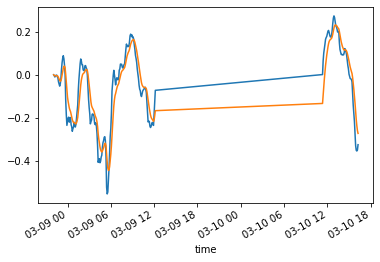

In [391]:
class MACD():
    macd = 0.0
    signal = 0.0
    
    def __init__(self, values, short_term, long_term, macd_length):
        ema_short_term = close.ewm(span=short_term).mean()
        ema_long_term = close.ewm(span=long_term).mean()

        self.macd = ema12 - ema26
        self.signal = self.macd.ewm(span=macd_length).mean()

    def plot(self):
        self.macd.plot()
        self.signal.plot()
        
    def values(self):
        return (self.macd.tail(1)[0], self.signal.tail(1)[0])
    
    def is_signal_above_macd(self):
        macd, signal = self.values()
        return signal > macd
    
    def is_signal_below_macd(self):
        macd, signal = self.values()
        return signal < macd
        
macd = MACD(close, short_term = 12, long_term = 26, macd_length = 9)
macd.plot()
print(macd.values())
print("is signal above macd:", macd.is_signal_above_macd())
print("is signal below macd:", macd.is_signal_below_macd())